In [27]:
print('Hello, world!')

Hello, world!


In [39]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import *
import warnings
from add_drive_cost import *

warnings.filterwarnings("ignore")


rd = pd.read_csv('rides.csv', sep=',', skipinitialspace=True)
wt = pd.read_csv('weather.csv', sep=',', skipinitialspace=True)
rd.columns = [i.lower().replace(' ', '_') for i in rd.columns]
wt.columns = [i.lower().replace(' ', '_') for i in wt.columns]
rd['end_date'] = pd.to_datetime(rd.end_date.astype(str).apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') if len(x) == 19 else pd.NA))
rd['start_date'] = pd.to_datetime(rd.start_date.astype(str).apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') if len(x) == 19 else pd.NA))
wt.datetime = wt.datetime.astype(str).apply(lambda x: dt.datetime.strptime(x.replace(' ', 'T'), '%Y-%m-%dT%H:%M:%S') if len(x) == 19 else pd.NA)
rd.drop_duplicates(subset=['id'], keep='first', inplace=True)

# Предобработка данных, очистка от выбросов и заполнение пропусков
#### Для начала найдём средние значения времени поездки, скорости, расстояния и т.п. для дальнейшего заполнения пропусков

In [40]:
rd1 = rd.copy()

In [41]:
rd1['end_date'] = pd.to_datetime(rd1['end_date'])
rd1['start_date'] = pd.to_datetime(rd1['start_date'])
rd1['duration_sec'] = (rd1['end_date'] - rd1['start_date']).dt.total_seconds()
rd1['duration_sec'] = rd1.duration_sec.where(rd1.duration_sec <= 1000000, pd.NA).dropna()


In [53]:
for i in rd1.columns[4:8]:
    rd1.loc[:, i] = rd1[i].astype(str).apply(lambda x: x.lower().replace(' ', '_'))

0.9336041157875818
0.0006653359946773121 5.311881188118812


,unnamed:_0.1,unnamed:_0,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,drive_dur,drive_cost,duration_sec,speed,speed_var,go
0,0,0,100340,2023-04-22 09:01:03,2023-04-22_09:24:45,шевченко,юго-восточный,майская,Октябрьский,4069.0,0,24,126,1422.0,2.861463,normal,МайскаяОктябрьскийМайскаяОктябрьский
1,1,1,100341,2023-04-22 09:01:07,2023-04-22_09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,0,29,146,1705.0,2.648094,normal,СпортивнаяоктябрьскийСпортивнаяоктябрьский
2,2,2,100342,2023-04-22 09:04:27,2023-04-22_09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,0,39,186,2299.0,1.966072,normal,СувороваленинскийСувороваленинский
3,3,3,100343,2023-04-22 09:06:34,2023-04-22_09:38:23,труда,центральный,рабочая,Северо-Западный,3881.0,0,32,158,1909.0,2.033002,normal,РабочаяСеверо-ЗападныйРабочаяСеверо-Западный
4,4,4,100344,2023-04-22 09:09:27,2023-04-22_09:40:07,первомайская,северо-западный,юбилейная,Юго-Восточный,4029.0,0,31,154,1840.0,2.189674,normal,ЮбилейнаяЮго-ВосточныйЮбилейнаяЮго-Восточный
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101671,102250,102250,197707,2023-07-31 23:45:06,2023-08-01_00:06:55,озерная,юго-восточный,первомайская,Северо-Западный,3302.0,0,22,140,1309.0,2.522536,normal,ПервомайскаяСеверо-ЗападныйПервомайскаяСеверо-...
101672,102251,102251,197708,2023-07-31 23:46:01,2023-08-01_00:25:35,мичурина,ленинский,садовая,Заречный,4992.0,0,40,230,2374.0,2.102780,normal,СадоваяЗаречныйСадоваяЗаречный
101673,102252,102252,197709,2023-07-31 23:48:04,2023-08-01_00:09:21,лермонтова,ленинский,куйбышева,Центральный,2781.0,0,22,140,1277.0,2.177760,normal,КуйбышеваЦентральныйКуйбышеваЦентральный
101674,102253,102253,197710,2023-07-31 23:51:41,2023-08-01_00:38:04,рябиновая,северо-западный,энергетиков,Юго-Восточный,6466.0,0,47,265,2783.0,2.323392,normal,ЭнергетиковЮго-ВосточныйЭнергетиковЮго-Восточный


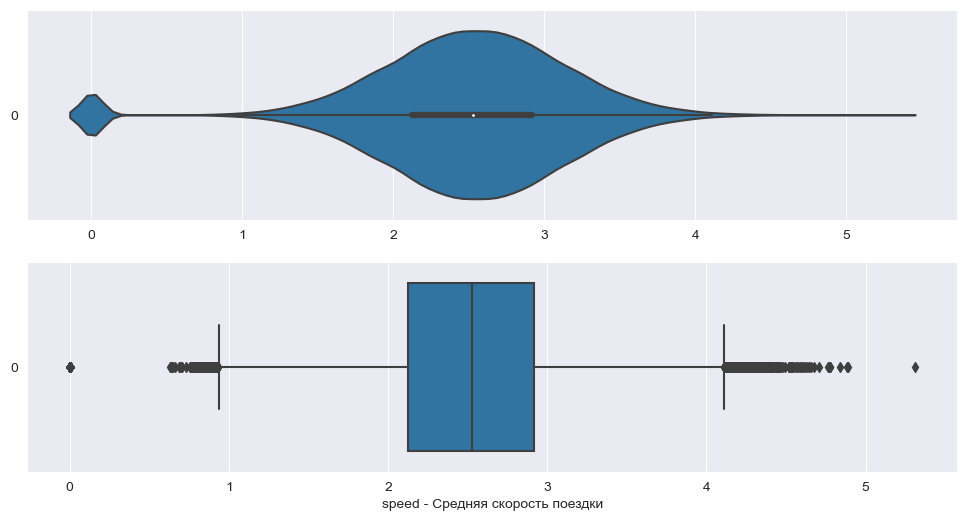

In [54]:
rd1['speed'] = (rd1.loc[:, 'distance'] / rd1.loc[:, 'duration_sec']).astype(float)
rd1['speed'] = rd1['speed'].where(rd1['speed'] <= 1000, pd.NA).dropna()  # находим скорость и ограничиваем экстремальные выбросы

fig, axes = plt.subplots(2, 1, figsize=(12, 6))
sns.violinplot(rd1.speed, orient='h', ax=axes[0])
sns.boxplot(rd1.speed, orient='h', ax=axes[1])
plt.xlabel('speed - Средняя скорость поездки')
print(rd1.speed.quantile(0.25) - 1.5 * (rd1.speed.quantile(0.75) - rd1.speed.quantile(0.25)))
print(min(rd1.speed), max(rd1.speed))
rd1

5.311881188118812

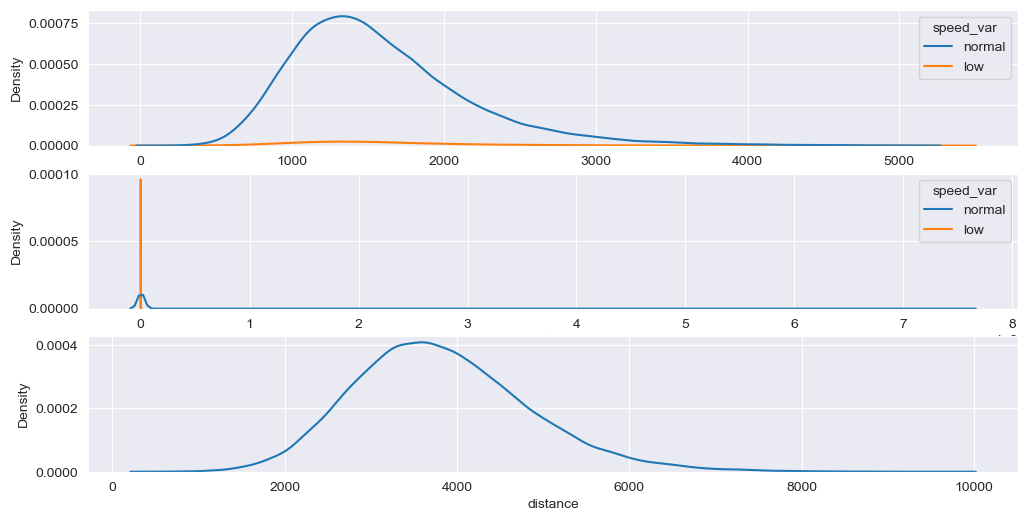

In [55]:
fig, axes = plt.subplots(3, 1, figsize=(12, 6))
rd1.loc[:, 'speed_var'] = rd1.speed.apply(lambda x: 'low' if x <= 0.9336 else 'normal')
sns.kdeplot(data=rd1, x='duration_sec', hue='speed_var', ax=axes[0])
sns.kdeplot(data=rd1, x='distance', hue='speed_var', ax=axes[1])
sns.kdeplot(data=rd1[rd1['speed'] >= 1], x='distance', ax=axes[2])
max(rd1.speed)

#### 5.31 м/с = 19.116 км/ч - вполне реальная величина скорости для самокатов, это намного ниже максимальной скорости большинства электросамокатов, а вот скорости, очень близкие к нулю - подозрительны, однако могут объясняться слишком большой продолжительностью поездки

<Axes: xlabel='duration_sec', ylabel='speed'>

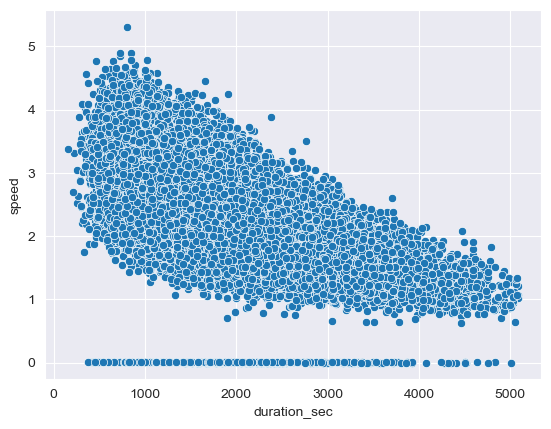

In [56]:
sns.scatterplot(data=rd1, x='duration_sec', y='speed')

<Axes: xlabel='distance', ylabel='duration_sec'>

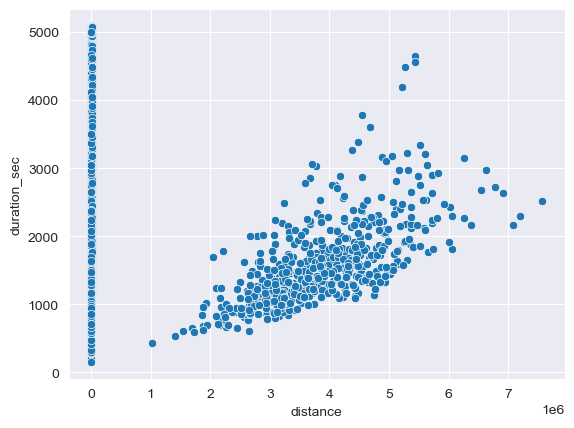

In [57]:
sns.scatterplot(data=rd1, x='distance', y='duration_sec')

In [58]:
rd1[rd1['speed_var'] == 'low']

,unnamed:_0.1,unnamed:_0,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,drive_dur,drive_cost,duration_sec,speed,speed_var,go
8,8,8,100348,2023-04-22 09:21:42,2023-04-22_09:39:04,западная,ленинский,озерная,Юго-Восточный,3.0,0,18,102,1042.0,0.002879,low,ОзернаяЮго-ВосточныйОзернаяЮго-Восточный
21,21,21,100360,2023-04-22 10:01:51,2023-04-22_10:31:17,лермонтова,ленинский,дружбы,центральный,5.0,0,30,210,1766.0,0.002831,low,ДружбыцентральныйДружбыцентральный
67,67,67,100405,2023-04-22 11:08:22,2023-04-22_12:00:35,ленина,ленинский,овражная,Центральный,5.0,0,53,348,3133.0,0.001596,low,ОвражнаяЦентральныйОвражнаяЦентральный
70,70,70,100408,2023-04-22 11:18:25,2023-04-22_11:36:19,ул._строительная,северо-западный,ул.строительная,северо-западный,4.0,0,18,138,1074.0,0.003724,low,ул.строительнаясеверо-западныйул.строительнаяс...
108,108,108,100443,2023-04-22 12:16:46,2023-04-22_12:50:14,заводская,северо-западный,свердлова,Центральный,4.0,0,34,234,2008.0,0.001992,low,СвердловаЦентральныйСвердловаЦентральный
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101430,102007,102007,197473,2023-07-31 19:44:01,2023-07-31_20:29:57,гоголя,центральный,энтузиастов,Центральный,3.0,0,46,306,2756.0,0.001089,low,энтузиастовЦентральныйэнтузиастовЦентральный
101495,102072,102072,197538,2023-07-31 20:23:15,2023-07-31_20:53:32,полевая,ленинский,ул.чапаева,Северо-Западный,3.0,0,31,216,1817.0,0.001651,low,ул.чапаеваСеверо-Западныйул.чапаеваСеверо-Запа...
101539,102117,102117,197581,2023-07-31 20:57:53,2023-07-31_21:33:29,октябрьская,заречный,солнечная,Центральный,6.0,0,36,246,2136.0,0.002809,low,солнечнаяЦентральныйсолнечнаяЦентральный
101571,102149,102149,197611,2023-07-31 21:22:02,2023-07-31_21:40:39,трудовая,центральный,гоголя,Центральный,4.0,0,19,144,1117.0,0.003581,low,гоголяЦентральныйгоголяЦентральный


In [63]:
rd1['start_location'] = rd1.loc[:, 'start_location'].astype(str).apply(lambda x: x.lower().replace(' ', '_').replace('ул', '').replace('.', '').replace('_', ''))
rd1['end_location'] = rd1.loc[:, 'end_location'].astype(str).apply(lambda x: x.lower().replace(' ', '_').replace('ул', '').replace('.', '').replace('_', ''))
 
rd1['go'] = rd1.loc[:, 'end_location'] + rd1.loc[:, 'end_district'] + rd1.loc[:, 'end_location'] + rd1.loc[:, 'end_district']
print(rd1.start_location.unique())
print(len(rd1.start_location.unique()))


['шевченко' 'чехова' 'буденного' 'труда' 'первомайская' 'лесная'
 'пролетарская' 'комарова' 'западная' 'свободы' 'коммунальная' 'зеленая'
 'шоссейная' 'центральная' 'новая' 'энтузиастов' 'подгорная' 'восточная'
 'лермонтова' 'школьная' 'пушкина' 'рябиновая' 'солнечная' 'мичурина'
 'партизанская' 'вокзальная' 'комсомольская' 'майская' 'красноармейская'
 'рабочая' 'почтовая' 'дачная' 'заводская' 'ломоносова' 'карламаркса'
 'советская' 'красная' 'дзержинского' 'энергетиков' 'пионерская' 'ленина'
 'сиреневая' 'гагарина' 'юбилейная' 'цветочная' 'набережная' 'сосновая'
 'спортивная' 'полевая' 'строительная' 'озерная' 'горького' 'южная'
 'некрасова' 'молодежная' 'чкалова' 'речная' 'парковая' 'строителей'
 'кирова' 'матросова' 'садовая' 'колхозная' 'луговая' 'крупской'
 'октябрьская' 'березовая' 'вишневая' 'береговая' 'дружбы' 'калинина'
 'суворова' 'дорожная' 'свердлова' 'куйбышева' 'нагорная' 'космонавтов'
 'северная' 'московская' 'гоголя' 'овражная' 'победы' 'кооперативная'
 'совхозная' 'за

,unnamed:_0.1,unnamed:_0,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,drive_dur,drive_cost,duration_sec,speed,speed_var,go,time_quantile
1310,1317,1317,101586,2023-04-23 14:01:28,2023-04-23_14:41:26,ленина,ленинский,ул.совхозная,центральный,4.0,0,40,270,2398.0,0.759206,low,ул.совхознаяцентральныйул.совхознаяцентральный,10
8548,8596,8596,108510,2023-05-01 18:07:19,2023-05-01_18:45:09,юбилейная,юго-восточный,ул._советская,Центральный,6.0,0,38,258,2270.0,0.888276,low,ул._советскаяЦентральныйул._советскаяЦентральный,9
23194,23322,23322,122551,2023-05-18 18:10:57,2023-05-18_18:56:27,совхозная,центральный,ул._цветочная,северо-западный,6.0,0,46,306,2730.0,0.801336,low,ул._цветочнаясеверо-западныйул._цветочнаясевер...,10
25807,25947,25947,125053,2023-05-21 11:33:12,2023-05-21_12:05:48,луговая,октябрьский,ул._гоголя,центральный,4.0,0,33,228,1956.0,0.002045,low,ул._гоголяцентральныйул._гоголяцентральный,8
26293,26436,26436,125512,2023-05-21 17:37:51,2023-05-21_18:18:04,восточная,октябрьский,цветочная,Северо Западный,3.0,0,41,317,2413.0,0.001243,low,цветочнаяСеверо ЗападныйцветочнаяСеверо Западный,10
34162,34354,34354,133057,2023-05-29 12:34:13,2023-05-29_13:15:25,мира,центральный,ул._южная,центральный,3.0,0,42,240,2472.0,0.680437,low,ул._южнаяцентральныйул._южнаяцентральный,10
39522,39738,39738,138187,2023-06-03 20:57:16,2023-06-03_21:17:07,почтовая,юго-восточный,ул._пролетарская,центральный,3.0,0,20,170,1191.0,0.002519,low,ул._пролетарскаяцентральныйул._пролетарскаяцен...,3
60128,60453,60453,157893,2023-06-23 20:26:39,2023-06-23_20:55:10,победы,юго-восточный,ул_пушкина,Центральный,5.0,0,29,204,1711.0,0.002922,low,ул_пушкинаЦентральныйул_пушкинаЦентральный,7
63042,63385,63385,160669,2023-06-25 21:53:30,2023-06-25_22:12:41,полевая,ленинский,ул._космонавтов,юго-восточный,3.0,0,20,170,1151.0,0.002606,low,ул._космонавтовюго-восточныйул._космонавтовюго...,3
67826,68189,68189,165249,2023-06-30 23:18:27,2023-06-30_23:46:32,шоссейная,заречный,ул._труда,центральный,4.0,0,29,175,1685.0,0.002374,low,ул._трудацентральныйул._трудацентральный,7


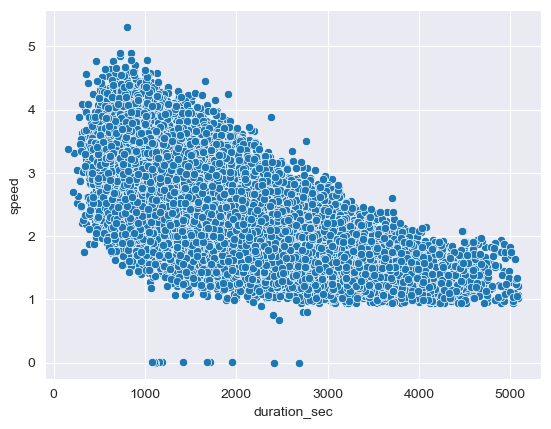

In [64]:
rd1['time_quantile'] = pd.qcut(rd1['duration_sec'], q=10, labels=range(1, 11))
mask = rd1['speed'] < 0.9336

rd1.loc[mask, 'speed'] = rd1.groupby(['go', 'time_quantile'])['speed'].transform('mean')

rd1['speed'] = rd1['speed'].fillna(rd1.groupby(['go', 'time_quantile'])['speed'].transform('mean'))

rd1['speed'] = rd1['speed'].fillna(rd1.groupby('go')['speed'].transform('mean'))  # Заполняем значения для поездок, у которых нет большого кол-ва квантилей

rd1.loc[:, 'speed_var'] = rd1.speed.apply(lambda x: 'low' if x <= 0.9336 else 'normal')
sns.scatterplot(data=rd1, x='duration_sec', y='speed')
rd1[rd1['speed_var'] == 'low']

#### ...

<Axes: xlabel='distance', ylabel='Density'>

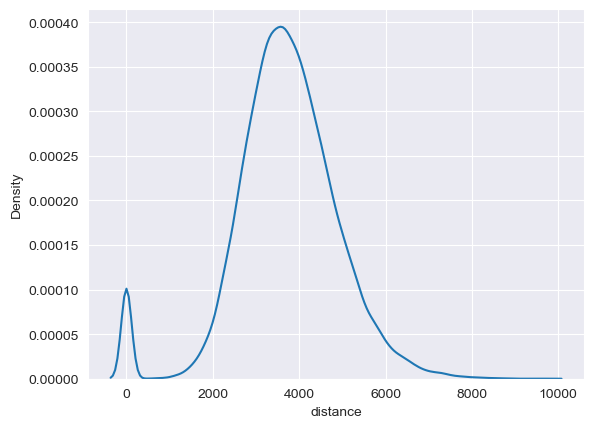

In [65]:
sns.kdeplot(data=rd1[rd1['distance'] < 100000], x='distance')

#### Скорее всего, поездки состоялись, но на определённых отрезках расстояние фиксируется неправильно, поэтому для заполнения пропусков в расстоянии мы будем использовать средние значения скорости по пунктам поездки (если будем использовать для заполнения общую среднюю скорость, то получим неправильные значения времени для отрезков с низкой скоростью).

154.0

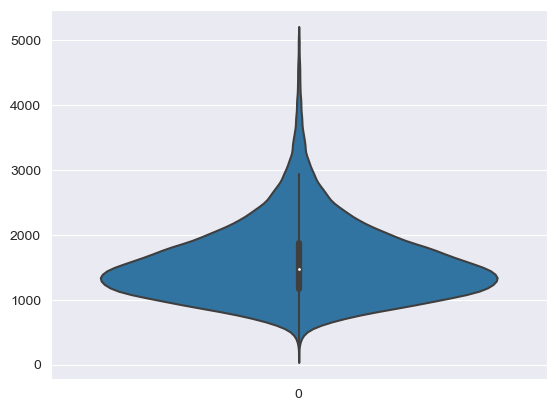

In [66]:
sns.violinplot(rd1.duration_sec)
min(rd1.duration_sec.where(rd1.duration_sec >= 0).dropna())

In [67]:
import numpy as np

# Calculate duration_sec based on speed if it is missing
rd1['duration_sec'] = rd1['duration_sec'].fillna(rd1['distance'] / rd1['speed'])
rd1['distance'] = rd1['distance'].fillna(rd1.speed * rd1.duration_sec)

# Fill in end_date based on start_date and duration_sec
rd1['end_date'] = rd1['start_date'] + pd.to_timedelta(rd1['duration_sec'], unit='s')

In [68]:
rd1

,unnamed:_0.1,unnamed:_0,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,drive_dur,drive_cost,duration_sec,speed,speed_var,go,time_quantile
0,0,0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,Октябрьский,4069.0,0,24,126,1422.0,2.861463,normal,майскаяОктябрьскиймайскаяОктябрьский,5
1,1,1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,0,29,146,1705.0,2.648094,normal,спортивнаяоктябрьскийспортивнаяоктябрьский,7
2,2,2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,0,39,186,2299.0,1.966072,normal,сувороваленинскийсувороваленинский,9
3,3,3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,Северо-Западный,3881.0,0,32,158,1909.0,2.033002,normal,рабочаяСеверо-ЗападныйрабочаяСеверо-Западный,8
4,4,4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,Юго-Восточный,4029.0,0,31,154,1840.0,2.189674,normal,юбилейнаяЮго-ВосточныйюбилейнаяЮго-Восточный,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101671,102250,102250,197707,2023-07-31 23:45:06,2023-08-01 00:06:55,озерная,юго-восточный,первомайская,Северо-Западный,3302.0,0,22,140,1309.0,2.522536,normal,первомайскаяСеверо-ЗападныйпервомайскаяСеверо-...,4
101672,102251,102251,197708,2023-07-31 23:46:01,2023-08-01 00:25:35,мичурина,ленинский,садовая,Заречный,4992.0,0,40,230,2374.0,2.102780,normal,садоваяЗаречныйсадоваяЗаречный,10
101673,102252,102252,197709,2023-07-31 23:48:04,2023-08-01 00:09:21,лермонтова,ленинский,куйбышева,Центральный,2781.0,0,22,140,1277.0,2.177760,normal,куйбышеваЦентральныйкуйбышеваЦентральный,4
101674,102253,102253,197710,2023-07-31 23:51:41,2023-08-01 00:38:04,рябиновая,северо-западный,энергетиков,Юго-Восточный,6466.0,0,47,265,2783.0,2.323392,normal,энергетиковЮго-ВосточныйэнергетиковЮго-Восточный,10


In [69]:
rd1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96817 entries, 0 to 101675
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   unnamed:_0.1    96817 non-null  int64         
 1   unnamed:_0      96817 non-null  int64         
 2   id              96817 non-null  int64         
 3   start_date      96817 non-null  datetime64[ns]
 4   end_date        96817 non-null  datetime64[ns]
 5   start_location  96817 non-null  object        
 6   start_district  96817 non-null  object        
 7   end_location    96817 non-null  object        
 8   end_district    96817 non-null  object        
 9   distance        96814 non-null  float64       
 10  promo           96817 non-null  int64         
 11  drive_dur       96817 non-null  int64         
 12  drive_cost      96817 non-null  int64         
 13  duration_sec    96817 non-null  float64       
 14  speed           96814 non-null  float64       
 15  speed_

In [70]:
rd1['distance_diff'] = rd1.distance - (rd1.speed * rd1.duration_sec)
rd1

,unnamed:_0.1,unnamed:_0,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,drive_dur,drive_cost,duration_sec,speed,speed_var,go,time_quantile,distance_diff
0,0,0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,Октябрьский,4069.0,0,24,126,1422.0,2.861463,normal,майскаяОктябрьскиймайскаяОктябрьский,5,0.000000e+00
1,1,1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,0,29,146,1705.0,2.648094,normal,спортивнаяоктябрьскийспортивнаяоктябрьский,7,0.000000e+00
2,2,2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,0,39,186,2299.0,1.966072,normal,сувороваленинскийсувороваленинский,9,0.000000e+00
3,3,3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,Северо-Западный,3881.0,0,32,158,1909.0,2.033002,normal,рабочаяСеверо-ЗападныйрабочаяСеверо-Западный,8,-4.547474e-13
4,4,4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,Юго-Восточный,4029.0,0,31,154,1840.0,2.189674,normal,юбилейнаяЮго-ВосточныйюбилейнаяЮго-Восточный,8,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101671,102250,102250,197707,2023-07-31 23:45:06,2023-08-01 00:06:55,озерная,юго-восточный,первомайская,Северо-Западный,3302.0,0,22,140,1309.0,2.522536,normal,первомайскаяСеверо-ЗападныйпервомайскаяСеверо-...,4,0.000000e+00
101672,102251,102251,197708,2023-07-31 23:46:01,2023-08-01 00:25:35,мичурина,ленинский,садовая,Заречный,4992.0,0,40,230,2374.0,2.102780,normal,садоваяЗаречныйсадоваяЗаречный,10,0.000000e+00
101673,102252,102252,197709,2023-07-31 23:48:04,2023-08-01 00:09:21,лермонтова,ленинский,куйбышева,Центральный,2781.0,0,22,140,1277.0,2.177760,normal,куйбышеваЦентральныйкуйбышеваЦентральный,4,0.000000e+00
101674,102253,102253,197710,2023-07-31 23:51:41,2023-08-01 00:38:04,рябиновая,северо-западный,энергетиков,Юго-Восточный,6466.0,0,47,265,2783.0,2.323392,normal,энергетиковЮго-ВосточныйэнергетиковЮго-Восточный,10,0.000000e+00


In [72]:
rd1.where(rd1.distance_diff > 10).dropna()

,unnamed:_0.1,unnamed:_0,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,drive_dur,drive_cost,duration_sec,speed,speed_var,go,time_quantile,distance_diff
128,128.0,128.0,100461.0,2023-04-22 12:40:47,2023-04-22 13:10:45,спортивная,октябрьский,свободы,Ленинский,4416111.0,0.0,30.0,210.0,1798.0,2.297078,normal,свободыЛенинскийсвободыЛенинский,8,4.411981e+06
135,135.0,135.0,100467.0,2023-04-22 12:49:51,2023-04-22 13:39:18,полевая,ленинский,пионерская,заречный,6627165.0,0.0,50.0,330.0,2967.0,1.905893,normal,пионерскаязаречныйпионерскаязаречный,10,6.621510e+06
604,608.0,608.0,100917.0,2023-04-22 19:00:13,2023-04-22 19:26:39,новая,северо-западный,ул._мичурина,ленинский,5146292.0,0.0,27.0,219.0,1586.0,2.498017,normal,ул._мичуриналенинскийул._мичуриналенинский,6,5.142330e+06
855,860.0,860.0,101154.0,2023-04-22 21:23:25,2023-04-22 21:41:45,совхозная,центральный,речная,юго-восточный,2992725.0,0.0,19.0,163.0,1100.0,3.030518,normal,речнаяюго-восточныйречнаяюго-восточный,2,2.989391e+06
1006,1012.0,1012.0,101299.0,2023-04-22 23:54:39,2023-04-23 00:23:58,дачная,центральный,ул.свободы,Ленинский,4273850.0,0.0,30.0,270.0,1759.0,2.567356,normal,ул.свободыЛенинскийул.свободыЛенинский,7,4.269334e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100739,101314.0,101314.0,196815.0,2023-07-31 07:16:48,2023-07-31 07:49:33,чапаева,северо-западный,пролетарская,Центральный,5330293.0,1.0,33.0,132.0,1965.0,2.373537,normal,пролетарскаяЦентральныйпролетарскаяЦентральный,8,5.325629e+06
100877,101452.0,101452.0,196944.0,2023-07-31 10:05:58,2023-07-31 10:27:43,трудовая,центральный,лермонтова,ленинский,3083436.0,0.0,22.0,140.0,1305.0,2.641263,normal,лермонтоваленинскийлермонтоваленинский,4,3.079989e+06
101246,101822.0,101822.0,197298.0,2023-07-31 17:28:58,2023-07-31 17:49:33,советская,центральный,дзержинского,Центральный,2184504.0,0.0,21.0,156.0,1235.0,2.592823,normal,дзержинскогоЦентральныйдзержинскогоЦентральный,4,2.181302e+06
101366,101942.0,101942.0,197410.0,2023-07-31 19:05:08,2023-07-31 19:31:14,комсомольская,заречный,чехова,заречный,3845980.0,0.0,27.0,192.0,1566.0,2.651677,normal,чеховазаречныйчеховазаречный,6,3.841827e+06


In [73]:
rd1.where(rd1.distance_diff > 10).dropna().distance_diff.min()

1018653.6729086465

#### Видно, что самое маленькое отклонение зафиксированной дистанции и дистанции, которая посчитана через скорость и время - больше 1000км (а также самая минимальная дистанция в этой таблице - 1019км), а значит зафиксированные дистанции неверны

In [74]:
mask = (rd1.distance_diff > 10) | (rd1.distance > 1000000)
rd1.loc[mask, 'distance'] = rd1.loc[mask, 'speed'] * rd1.loc[mask, 'duration_sec']
rd1

,unnamed:_0.1,unnamed:_0,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,drive_dur,drive_cost,duration_sec,speed,speed_var,go,time_quantile,distance_diff
0,0,0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,Октябрьский,4069.0,0,24,126,1422.0,2.861463,normal,майскаяОктябрьскиймайскаяОктябрьский,5,0.000000e+00
1,1,1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,0,29,146,1705.0,2.648094,normal,спортивнаяоктябрьскийспортивнаяоктябрьский,7,0.000000e+00
2,2,2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,0,39,186,2299.0,1.966072,normal,сувороваленинскийсувороваленинский,9,0.000000e+00
3,3,3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,Северо-Западный,3881.0,0,32,158,1909.0,2.033002,normal,рабочаяСеверо-ЗападныйрабочаяСеверо-Западный,8,-4.547474e-13
4,4,4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,Юго-Восточный,4029.0,0,31,154,1840.0,2.189674,normal,юбилейнаяЮго-ВосточныйюбилейнаяЮго-Восточный,8,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101671,102250,102250,197707,2023-07-31 23:45:06,2023-08-01 00:06:55,озерная,юго-восточный,первомайская,Северо-Западный,3302.0,0,22,140,1309.0,2.522536,normal,первомайскаяСеверо-ЗападныйпервомайскаяСеверо-...,4,0.000000e+00
101672,102251,102251,197708,2023-07-31 23:46:01,2023-08-01 00:25:35,мичурина,ленинский,садовая,Заречный,4992.0,0,40,230,2374.0,2.102780,normal,садоваяЗаречныйсадоваяЗаречный,10,0.000000e+00
101673,102252,102252,197709,2023-07-31 23:48:04,2023-08-01 00:09:21,лермонтова,ленинский,куйбышева,Центральный,2781.0,0,22,140,1277.0,2.177760,normal,куйбышеваЦентральныйкуйбышеваЦентральный,4,0.000000e+00
101674,102253,102253,197710,2023-07-31 23:51:41,2023-08-01 00:38:04,рябиновая,северо-западный,энергетиков,Юго-Восточный,6466.0,0,47,265,2783.0,2.323392,normal,энергетиковЮго-ВосточныйэнергетиковЮго-Восточный,10,0.000000e+00


In [75]:
rd1['distance_diff'] = rd1.distance - (rd1.speed * rd1.duration_sec)
print(rd1.where(rd1.distance_diff > 10).dropna())

Empty DataFrame
Columns: [unnamed:_0.1, unnamed:_0, id, start_date, end_date, start_location, start_district, end_location, end_district, distance, promo, drive_dur, drive_cost, duration_sec, speed, speed_var, go, time_quantile, distance_diff]
Index: []


<Axes: xlabel='distance', ylabel='duration_sec'>

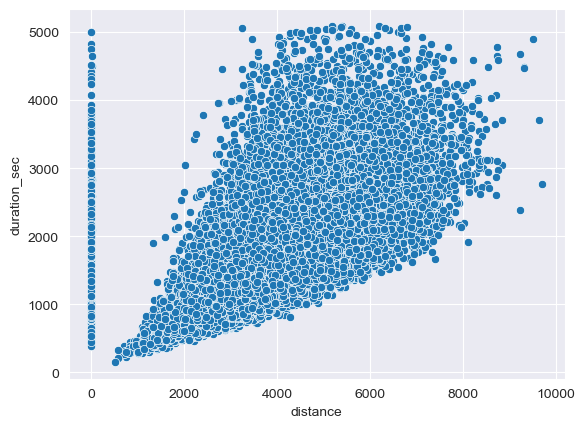

In [76]:
sns.scatterplot(data=rd1, x='distance', y='duration_sec')

In [77]:
rd1.distance.max()

9710.0

In [78]:
rd1.where(rd1.distance == rd1.distance.max()).dropna()

,unnamed:_0.1,unnamed:_0,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,drive_dur,drive_cost,duration_sec,speed,speed_var,go,time_quantile,distance_diff
99889,100457.0,100457.0,196000.0,2023-07-30 16:44:29,2023-07-30 17:30:35,ленина,ленинский,комсомольская,Заречный,9710.0,0.0,47.0,359.0,2766.0,3.510484,normal,комсомольскаяЗаречныйкомсомольскаяЗаречный,10,0.0


In [79]:
Q1_dis = rd1.distance.quantile(0.25) - 1.5 * (rd1.distance.quantile(0.75) - rd1.distance.quantile(0.25))
rd1[rd1.distance < Q1_dis]

,unnamed:_0.1,unnamed:_0,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,drive_dur,drive_cost,duration_sec,speed,speed_var,go,time_quantile,distance_diff
8,8,8,100348,2023-04-22 09:21:42,2023-04-22 09:39:04,западная,ленинский,озерная,Юго-Восточный,3.0,0,18,102,1042.0,2.801106,normal,озернаяЮго-ВосточныйозернаяЮго-Восточный,2,-2915.752920
21,21,21,100360,2023-04-22 10:01:51,2023-04-22 10:31:17,лермонтова,ленинский,дружбы,центральный,5.0,0,30,210,1766.0,2.282265,normal,дружбыцентральныйдружбыцентральный,7,-4025.480175
67,67,67,100405,2023-04-22 11:08:22,2023-04-22 12:00:35,ленина,ленинский,овражная,Центральный,5.0,0,53,348,3133.0,1.604298,normal,овражнаяЦентральныйовражнаяЦентральный,10,-5021.266215
70,70,70,100408,2023-04-22 11:18:25,2023-04-22 11:36:19,строительная,северо-западный,ул.строительная,северо-западный,4.0,0,18,138,1074.0,2.373349,normal,ул.строительнаясеверо-западныйул.строительнаяс...,2,-2544.976625
108,108,108,100443,2023-04-22 12:16:46,2023-04-22 12:50:14,заводская,северо-западный,свердлова,Центральный,4.0,0,34,234,2008.0,1.858141,normal,свердловаЦентральныйсвердловаЦентральный,9,-3727.146728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101430,102007,102007,197473,2023-07-31 19:44:01,2023-07-31 20:29:57,гоголя,центральный,энтузиастов,Центральный,3.0,0,46,306,2756.0,1.513371,normal,энтузиастовЦентральныйэнтузиастовЦентральный,10,-4167.849639
101495,102072,102072,197538,2023-07-31 20:23:15,2023-07-31 20:53:32,полевая,ленинский,ул.чапаева,Северо-Западный,3.0,0,31,216,1817.0,1.843053,normal,ул.чапаеваСеверо-Западныйул.чапаеваСеверо-Запа...,8,-3345.826874
101539,102117,102117,197581,2023-07-31 20:57:53,2023-07-31 21:33:29,октябрьская,заречный,солнечная,Центральный,6.0,0,36,246,2136.0,1.981906,normal,солнечнаяЦентральныйсолнечнаяЦентральный,9,-4227.351117
101571,102149,102149,197611,2023-07-31 21:22:02,2023-07-31 21:40:39,трудовая,центральный,гоголя,Центральный,4.0,0,19,144,1117.0,2.570476,normal,гоголяЦентральныйгоголяЦентральный,3,-2867.221242


#### Видно, что значение по скорости и времени сильно различаются с зафиксированными значениями (столбец distance_diff), скорее всего зафиксированное значение неверно - рассмотрим их

<Axes: xlabel='distance', ylabel='duration_sec'>

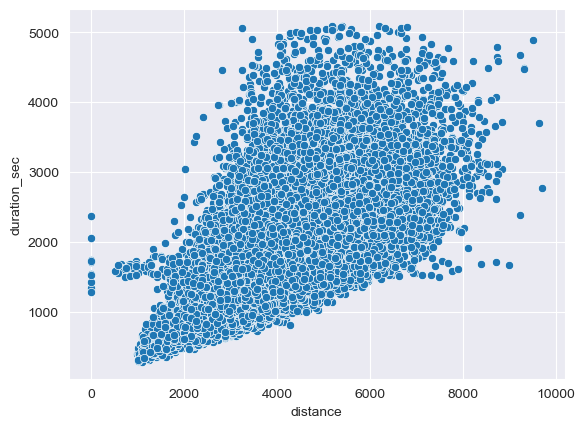

In [80]:
mask = (rd1.distance < Q1_dis) | (rd1.distance > 1000000)
rd1.loc[mask, 'distance'] = rd1.loc[mask, 'speed'] * rd1.loc[mask, 'duration_sec']
rd1.loc[mask, 'duration_sec'] = rd1.groupby('go')['duration_sec'].transform('mean')
sns.scatterplot(data=rd1, x='distance', y='duration_sec')

In [81]:
rd1[rd1.duration_sec > 1000000]

,unnamed:_0.1,unnamed:_0,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,drive_dur,drive_cost,duration_sec,speed,speed_var,go,time_quantile,distance_diff


In [ ]:
rd1.to_csv('rides_final.csv')

# Очистим от выбросов и пропусков weather

In [3]:
wt1 = wt.drop(wt.index[0]).copy()

In [4]:
wt1[wt1.temperature.isnull()]

,unnamed:_0,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration
363,363,2023-04-16 02:00:00,NaN,0.3,13.32,3.671294,100,0
364,364,2023-04-16 03:00:00,NaN,0.4,13.32,4.452954,98,0
365,365,2023-04-16 04:00:00,NaN,0.4,13.32,4.802999,100,0
366,366,2023-04-16 05:00:00,NaN,0.3,13.679999,4.379589,100,0
367,367,2023-04-16 06:00:00,NaN,0.2,14.4,5.0528407,100,0
368,368,2023-04-16 07:00:00,NaN,0.3,15.4800005,6.379216,100,0
369,369,2023-04-16 08:00:00,NaN,0.2,19.08,9.957108,100,0
370,370,2023-04-16 09:00:00,NaN,0.2,24.48,10.383987,100,0
371,371,2023-04-16 10:00:00,NaN,0.2,24.48,7.7043357,100,0
372,372,2023-04-16 11:00:00,NaN,0.3,24.84,8.534353,91,4.8484864


In [5]:
wt1.dropna(subset=['temperature'], how='all').loc[wt1.drop(columns='temperature').isnull().any(axis=1)]

,unnamed:_0,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration
935,935,2023-05-09 22:00:00,13.900246,0.5,30.960001,NaN,94,0
936,936,2023-05-09 23:00:00,13.780245,0.1,30.599998,NaN,76,0
937,937,2023-05-10 00:00:00,13.490245,0,31.68,NaN,91,0
938,938,2023-05-10 01:00:00,13.290245,0,33.839996,NaN,62,0
1296,1296,2023-05-24 23:00:00,10.470245,0,23.039999,NaN,57,0
...,...,...,...,...,...,...,...,...
2792,2792,2023-07-26 07:00:00,14.240245,0.5,23.4,8.404285,NaN,7.2727275
2841,2841,2023-07-28 08:00:00,23.130245,0,27.359999,11.480557,29,NaN
2842,2842,2023-07-28 09:00:00,24.820246,0,29.519999,13.18308,42,NaN
2843,2843,2023-07-28 10:00:00,25.320246,0,39.96,15.807239,40,NaN


#### Видно, что есть достаточно много пустых значений, стоящих рядом, поэтому заполнять будем регрессией, а не интерполяцией или по соседним значениям

In [6]:
wt1['datetime'] = pd.to_datetime(wt1['datetime'])
wt1['day'] = wt1['datetime'].dt.day
wt1['hour'] = wt1['datetime'].dt.hour
wt1['month'] = wt1['datetime'].dt.month
wt1['hour_total'] = wt1['datetime'].dt.hour + wt1.datetime.dt.dayofyear * 24
bins = [-1, 6, 12, 18, 23]

from sklearn.preprocessing import OneHotEncoder

# Categorize the 'hour' column into specific labels
labels = ['night', 'morning', 'evening', 'afternoon']
wt1['hour_category'] = pd.cut(wt1['hour'], bins=bins, labels=labels, right=False, ordered=False)

# Initialize OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the 'hour_category' column
hour_category_encoded = encoder.fit_transform(wt1[['hour_category']].astype(str))

# Convert the encoded data into a DataFrame
hour_category_encoded_df = pd.DataFrame(hour_category_encoded.toarray(), columns=encoder.get_feature_names_out(['hour_category']))

# Concatenate the encoded hour category data with the original data
wt1 = pd.concat([wt1, hour_category_encoded_df], axis=1)

# Drop the original 'hour_category' column
wt1 = wt1.drop('hour_category', axis=1)

In [7]:
# Map months to seasons
month_to_season = {1: 'winter', 2: 'winter', 3: 'spring', 4: 'spring', 5: 'spring', 6: 'summer', 7: 'summer', 8: 'summer', 9: 'fall', 10: 'fall', 11: 'fall', 12: 'winter'}

# Replace 'month' column with 'season'
wt1['season'] = wt1['month'].map(month_to_season)

# Initialize OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the 'season' column
season_encoded = encoder.fit_transform(wt1[['season']])

# Convert the encoded data into a DataFrame
season_encoded_df = pd.DataFrame(season_encoded.toarray(), columns=encoder.get_feature_names_out(['season']))

# Concatenate the encoded season data with the original data
wt1 = pd.concat([wt1, season_encoded_df], axis=1)

# Drop the original 'season' column
wt1 = wt1.drop('season', axis=1)

In [8]:
wt1.columns

Index(['unnamed:_0', 'datetime', 'temperature', 'precipitation_total',
       'wind_gust', 'wind_speed', 'cloud_cover_total', 'sunshine_duration',
       'day', 'hour', 'month', 'hour_total', 'hour_category_afternoon',
       'hour_category_evening', 'hour_category_morning', 'hour_category_nan',
       'hour_category_night', 'season_spring', 'season_summer', 'season_nan'],
      dtype='object')

In [25]:
wt1.corr().to_excel('aaa.xlsx')

Рассмотрим самые сильные корреляции: 
Влияние даты на температуру и время солнечного света объясняется тем, что в датасете данные с середины весны и до августа - в период, когда средняя температура возрастает, а время солнечного света увеличивается к лету.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# Separate data with and without missing temperature values
train_data = wt1.dropna(subset=['temperature'])

# Define the features and target
X = train_data['precipitation_total,wind_gust,cloud_cover_total,sunshine_duration,day,hour,month,season_spring,season_summer,hour_category_night,hour_category_morning,hour_category_evening,hour_category_afternoon,hour_total'.split(',')]  # Specify your features
y = train_data['temperature']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = make_pipeline(SimpleImputer(), LinearRegression())
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

if mse > 0.5 or r2 < 0.5:
    print("Mean Squared Error:", mse)
    print("R-squared Score:", r2)
    features_for_prediction = ['precipitation_total', 'wind_gust', 'cloud_cover_total', 'sunshine_duration',
                               'day', 'hour', 'month', 'season_spring', 'season_summer',
                               'hour_category_night', 'hour_category_morning', 'hour_category_evening', 'hour_category_afternoon', 'hour_total']

# Make predictions for all values in the DataFrame using the selected features
    all_predictions = model.predict(wt1[features_for_prediction])

# Store the predictions in the 'temperature_predictions' column
    wt1['temperature_predictions'] = all_predictions

else:
    # Predict missing values
    X_missing = wt1.loc[wt1['temperature'].isnull(), ['precipitation_total,wind_gust,cloud_cover_total,sunshine_duration,day,hour,month,season_spring,season_summer,hour_category_night,hour_category_morning,hour_category_evening,hour_category_afternoon'.split(',')]]
    predicted_temperatures = model.predict(X_missing)

    # Fill in the missing temperature values
    wt1.loc[wt1['temperature'].isnull(), 'temperature'] = predicted_temperatures


wt1['temperature_interpolated'] = wt1['temperature'].interpolate(method='quadratic', limit=100)

Mean Squared Error: 11.952225916284547
R-squared Score: 0.7483157520461342


In [14]:
rows_with_missing_temp = wt1[wt1['temperature'].isnull()]

# Include neighboring days (e.g., previous and next rows) for each row with missing 'temperature'
neighboring_rows = wt1.loc[rows_with_missing_temp.index - 1].append(wt1.loc[rows_with_missing_temp.index]).append(wt1.loc[rows_with_missing_temp.index + 24])

# Display the rows with missing 'temperature' and neighboring days
print(neighboring_rows)

KeyError: '[-1] not in index'

In [15]:
print(len(wt1.hour_total.unique()), len(wt1))

3673 3673


<Axes: xlabel='datetime', ylabel='temperature_predictions'>

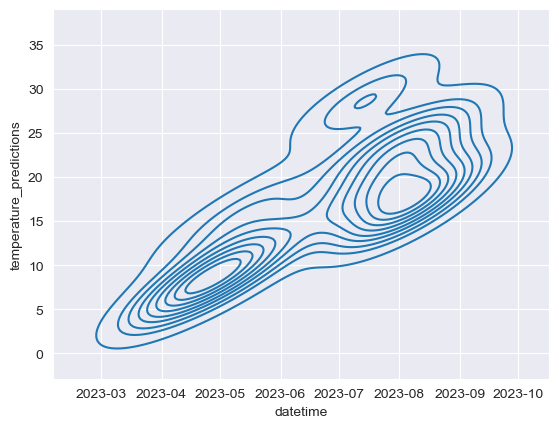

In [23]:
sns.kdeplot(data=wt1[wt1['temperature'].isnull()], x='datetime', y='temperature_predictions')

In [ ]:
wt1[wt1.temperature_predictions.isnull()]

In [ ]:
wt1.to_csv('kpolyakov.spb.csv')